In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = './data/plantvillage/'
print(data_dir)

./data/plantvillage/


In [4]:
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

Apple___Apple_scab --> 630
Apple___Black_rot --> 621
Apple___Cedar_apple_rust --> 275
Apple___healthy --> 1645
Blueberry___healthy --> 1502
Cherry_(including_sour)___healthy --> 854
Cherry_(including_sour)___Powdery_mildew --> 1052
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot --> 513
Corn_(maize)___Common_rust_ --> 1192
Corn_(maize)___healthy --> 1162
Corn_(maize)___Northern_Leaf_Blight --> 985
Grape___Black_rot --> 1180
Grape___Esca_(Black_Measles) --> 1383
Grape___healthy --> 423
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) --> 1076
Orange___Haunglongbing_(Citrus_greening) --> 5507
Peach___Bacterial_spot --> 2297
Peach___healthy --> 360
Pepper,_bell___Bacterial_spot --> 997
Pepper,_bell___healthy --> 1478
Potato___Early_blight --> 1000
Potato___healthy --> 152
Potato___Late_blight --> 1000
Raspberry___healthy --> 371
Soybean___healthy --> 5090
Squash___Powdery_mildew --> 1835
Strawberry___healthy --> 456
Strawberry___Leaf_scorch --> 1109
Tomato___Bacterial_spot --> 2127
Tomato___

<BarContainer object of 38 artists>

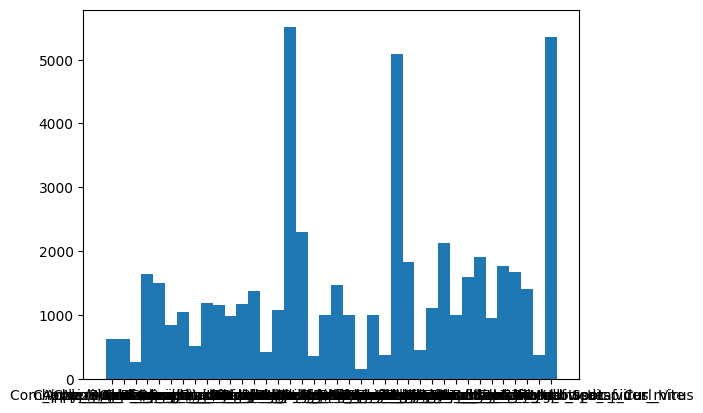

In [49]:
import os
data_path = "./data/plantvillage/"
name = []
count = []
for labels in os.listdir(data_path):
    
    full_labels = os.path.join(data_path, labels)
    label_len = len(os.listdir(full_labels))
    name.append(labels)
    count.append(label_len)
    print (f"{labels} --> {label_len}")
plt.bar(name, count)

- Class Weight
- Thresholding

In [5]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.8, 0.1, 0.1])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 43445 | No of val: 5430 | No of test: 5430 | 


In [6]:
# data transforms
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transformer = {
	'train':
		transforms.Compose([
		transforms.RandomResizedCrop(248),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
	'val':
		transforms.Compose([
		transforms.CenterCrop(248),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	])
}
transform = transforms.ToTensor()

In [7]:

class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		if self.transform:
			x = self.transform(self.dataset[index][0])
		else:
			x = self.dataset[index][0]
		y = self.dataset[index][1]
		return x, y

	def __len__(self):
		return len(self.dataset)

In [8]:
class ConvNet(nn.Module):
	def __init__(self):
		super(ConvNet, self).__init__()
		self.dropout = nn.Dropout(0.2)
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
		self.fc1 = nn.Linear(59536, 120)   # (n + 2p -f)/s + 1
		self.fc2 = nn.Linear(120, 84)        
		self.fc3 = nn.Linear(84, 38)    
			
	def forward(self, x):
		out = self.pool(F.relu(self.conv1(x)))
		out = self.pool(F.relu(self.conv2(out)))
		out = out.view(-1, 59536)
		out = F.relu(self.fc1(out))
		out = self.dropout(out)
		out = F.relu(self.fc2(out))
		out = self.fc3(out)
		return out
	
model = ConvNet().to(device)

In [9]:
train_data = PlantVillageDataset(train, data_transformer['train'])
val_data = PlantVillageDataset(val, data_transformer['val'])
test_data = PlantVillageDataset(test, transform)
# for i in range(6):
#     plt.subplot(2,3, i+1)
#     plt.imshow(train_data[i][0], cmap='grey')
#     print(f'{i} is class {train_data[i][1]}')
# plt.show()
x, y = train_data[0]
x, y

(tensor([[[ 0.3823,  0.3823,  0.3823,  ...,  0.3652,  0.3652,  0.3652],
          [ 0.3823,  0.3823,  0.3823,  ...,  0.3309,  0.3309,  0.3481],
          [ 0.3823,  0.3823,  0.3823,  ...,  0.3138,  0.3138,  0.3309],
          ...,
          [-0.3712, -0.3369, -0.2856,  ...,  0.0227,  0.0056, -0.0458],
          [-0.4054, -0.4397, -0.4054,  ..., -0.0287, -0.0458, -0.0801],
          [-0.4226, -0.5082, -0.5082,  ..., -0.0801, -0.0972, -0.1314]],
 
         [[ 0.5378,  0.5378,  0.5378,  ...,  0.5028,  0.5028,  0.5028],
          [ 0.5203,  0.5203,  0.5203,  ...,  0.4853,  0.4853,  0.5028],
          [ 0.5203,  0.5203,  0.5203,  ...,  0.4853,  0.4853,  0.5028],
          ...,
          [-0.2150, -0.1800, -0.1275,  ...,  0.6954,  0.6604,  0.5903],
          [-0.2500, -0.2850, -0.2500,  ...,  0.6429,  0.6078,  0.5553],
          [-0.2675, -0.3550, -0.3550,  ...,  0.5903,  0.5553,  0.5028]],
 
         [[ 0.6705,  0.6705,  0.6705,  ...,  0.7228,  0.7228,  0.7228],
          [ 0.6879,  0.6879,

In [10]:
#hyperparameters
n_input_size = 248*248*3
n_hidden_size = 10
n_classes = 38
n_epochs = 1
batch_size = 1
learning_rate = 0.001

In [11]:
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# # for i in range(1):
# x = iter(train_data_loader)
# next(x)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(summary(model, batch_dim=batch_size))

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Dropout: 1-1                           --
├─Conv2d: 1-2                            456
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            2,416
├─Linear: 1-5                            7,144,440
├─Linear: 1-6                            10,164
├─Linear: 1-7                            3,230
Total params: 7,160,706
Trainable params: 7,160,706
Non-trainable params: 0


In [13]:
# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
losses = []
print(f'\n {"="*30}')
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # if(epoch + 1) % 10 == 0:
    losses.append(loss.item())
    print(f'| Epoch: {epoch+1}/{n_epochs}\t| Loss: {loss.item():.4f} |')
print(f' {"="*30}\n')
end_time = time.time() - start_time
#test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    accuracy = n_correct * 100.0 / n_samples
    print(f'\tAccuracy: {accuracy:.2f}%')
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')
plt.plot(losses)
plt.show()